# MAC0318 Introdu√ß√£o √† Programa√ß√£o de Rob√¥s M√≥veis

## Estima√ß√£o de estado

Vamos construir um estimador de cren√ßa usando um filtro bayesiano para um dom√≠nio simples no qual um rob√¥ se locomove entre 4 c√©lulas conectadas como na figura abaixo, e sensoria apenas a cor de cada c√©lula:


<figure style="text-align: center">
    <img src="img/mundo1d-num.png" width=400>
</figure>

Para esse dom√≠nio simples, a vari√°vel de estado ser√° representada por um processo estoc√°stico discreto $X_t$ que toma valores em $\{1,2,3,4\}$ e a vari√°vel de observa√ß√£o ser√° representada por um processo estoc√°stico discreto $Y_t$ que toma valores bin√°rios representando as cores vermelha ($Y=0$) e verde ($Y=1$). O agente possui a√ß√µes de mover-se √† c√©lula √† esquerda ($u=-1$) ou √† direita ($u=1$), que nem sempre s√£o bem sucedidas. Por √∫ltimo, vamos tambem assumir que o tempo √© discreto, ou seja, que o agente atualiza sua cren√ßa em instantes de tempo $t_0, t_0 + 1, \ldots$, tamb√©m conhecidos como est√°gios de decis√£o.

In [1]:
# Vamos carregar os pacotes necess√°rios

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Vamos representar os suportes de cada vari√°vel aleat√≥ria por vari√°veis de programa√ß√£o de mesmo nome.

In [2]:
X = [1, 2, 3, 4]     # estados (c√©lulas)
Y = [0, 1]           # observa√ß√µes: 0 - vermelho, 1 - verde
mapa = [0, 1, 1, 0]  # cont√©m cor de cada c√©lula

Vamos especificar um sensor perfeito, ou seja, que identifica a cor exata da c√©lula na qual o rob√¥ se encontra.

In [3]:
def sensor(y, x): 
    ''' Returns P(Y=y | X=x). '''
    if mapa[x-1] == y:
        return 1.0
    else:
        return 0.0

In [4]:
for x in X:
    for y in Y:
        print(f'P(Y={y}|X={x}) =', sensor(y,x))

P(Y=0|X=1) = 1.0
P(Y=1|X=1) = 0.0
P(Y=0|X=2) = 0.0
P(Y=1|X=2) = 1.0
P(Y=0|X=3) = 0.0
P(Y=1|X=3) = 1.0
P(Y=0|X=4) = 1.0
P(Y=1|X=4) = 0.0


Vamos especificar a fun√ß√£o de transi√ß√£o (modelo do processo, de din√¢mica ou de a√ß√£o):
$$
P(X_{t+1}=x' | X_t=x, u) = \begin{cases} 1/4 & \text{ se } x'=x \text{ ou } x'=x+2u\\1/2 & \text{se } x'=x+u \end{cases}
$$

De acordo com a fun√ß√£o acima, o rob√¥ se movimenta para a c√©lula pretendida com probabilidade 1/2 e com probabilidade 1/2 a a√ß√£o falha e ele permance na mesma c√©lula ou atinge a c√©lula seguinte √† pretendida. Nas c√©lulas sem vizinhan√ßa na dire√ß√£o pretendida (por exemplo, $X=1$ para a√ß√£o $u=1$) a a√ß√£o faz o agente permanecer na mesma c√©lula, por exemplo, $P(X_{t+1}=1|X_t=1, u=-1)=1$.

Vamos representar as distribui√ß√µes condicionais $P(X_{t+1}=x'|X_t=x, u)$ para uma dada a√ß√£o $u$ como uma matriz $T[x',x]$ cuja coluna indica o valor do estado atual $x$ e cuja linha indica o valor do estado futuro $x'$. Dessa forma, os valores em cada coluna devem somar 1.

In [5]:
# T(x,u,x') = P(X'=x'|X=x,u)

T = {
    1: # u = direita 
     np.matrix( [[1/4, 0.0, 0.0, 0.0],  
                 [1/2, 1/4, 0.0, 0.0],
                 [1/4, 1/2, 1/4, 0.0],
                 [0.0, 1/4, 3/4, 1.0]]),

   -1: # u = esquerda
     np.matrix( [[1.0, 3/4, 1/4, 0.0], 
                 [0.0, 1/4, 1/2, 1/4],
                 [0.0, 0.0, 1/4, 1/2], 
                 [0.0, 0.0, 0.0, 1/4]])
    }

## Filtro Bayesiano

O Filtro bayesiano calcula a cren√ßa 
$$
 \text{bel}(x_t) = P(X_t = x_t | y_0,\ldots,y_t,u_0,\ldots,u_t)
$$
sobre o estado atual $X_t$ a partir de todas as a√ß√µes $u$ e observa√ß√µes $y$ anteriores. 

Para facilitar as computa√ß√µes, vamos representar a cren√ßa por um vetor (ou tensor unidimensional)

```python
  bel = np.array([p1, p2, p3, p4]).T
```

onde `p1`, ..., `p4` s√£o as probabilidades de cada c√©lula (estado).

In [6]:
# Cren√ßa uniforme sobre todos os estado -- m√°xima ignor√¢ncia/incerteza

bel = np.array([1/4, 1/4, 1/4, 1/4]).T

A fun√ß√£o a seguir exibe a cren√ßa em um dado instante

In [7]:
def show_belief(p):
    ''' Shows bar plot of belief funciton. '''
    p = p.flatten()
    states = plt.bar(X, p)
    colors = {0: 'red', 1: 'green'}
    for i in range(len(states)):
        states[i].set_facecolor(colors[mapa[i]])
    plt.xticks(X)
    plt.ylim([0, 1])
    plt.ylabel('bel(X)')
    plt.xlabel('X') 

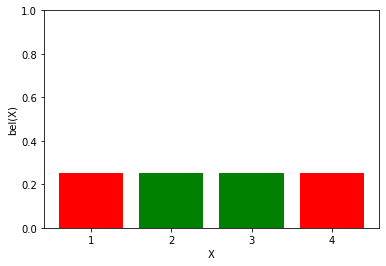

In [8]:
# Mostrando a cren√ßa atual

show_belief(bel)

O Filtro Bayesiano assume que **estado e observa√ß√£o s√£o markovianos** para  obter uma f√≥rmula recursiva para o c√°lculo da cren√ßa atual a partir da cren√ßa pr√©via em duas etapas: 

- Corre√ß√£o, na qual informa√ß√£o de observa√ß√£o √© incorporada √† cren√ßa, e 
- Predi√ß√£o, na qual informa√ß√£o sobre a a√ß√£o executada pelo agente √© considerada.

### Corre√ß√£o

Considere que nosa cren√ßa no instante $t$ √© a distribui√ß√£o de probabilidades $\text{bel}_t(x)=P(X_t = x)$ e que recebemos uma observa√ß√£o $Y_t=y$. Note que omitimos a depend√™ncia em informa√ß√µes anteriores, pois elas n√£o s√£o relevantes devido √† hip√≥tese de markovianidade do filtro. A etapa de corre√ß√£o atualiza a cren√ßa por:

$$
    \text{bel}_{t+1}(x) = P(X_{t+1}=x|y) = \frac{p(y | x)\text{bel}_t(x)}{p(y)}
$$

O denominador da equa√ß√£o acima √© constante em rela√ß√£o ao estado $x$. Dessa forma, e lembrando a propriedade de distribui√ß√£o de probabilidades, $\sum_{x=1}^4 P(X_{t+1}=x) = 1$, podemos calcul√°-la como a constante de normaliza√ß√£o da vers√£o n√£o normalizada:

$$
    \tilde{\text{bel}}_{t+1}(x) = p(y | x)\text{bel}_t(x) .
$$

Em termos vetoriais, a equa√ß√£o acima computa o produto ponto-a-ponto de dois vetores cujas posi√ß√µes correspondem aos estados $x$.

In [9]:
def correct(b, y):
    ''' Update belief vector b given observation y -- Calls sensor model sensor(y) = P(Y=y|X).  '''
    tilde_bel = np.array([sensor(y,x) for x in X]).T # P(Y=y|X=x)
    tilde_bel *= b # bel(X) * P(y|X)
    # normaliza e atualiza vetor de cren√ßa
    b[:] = tilde_bel/np.sum(tilde_bel) 


Vamos testar a equa√ß√£o de corre√ß√£o quando observamos a cor verde

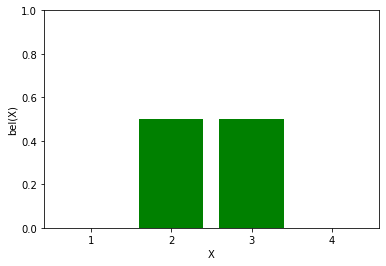

In [10]:
# observar (verde)
correct(bel, 1)

show_belief(bel) 

### Predi√ß√£o

A segunda etapa do filtro bayesiano atualiza a cren√ßa para uma dada a√ß√£o $u$ por meio da f√≥rmula:
$$
  \text{bel}_{t+1}(x') = \sum_{x} P(X_{t+1}=x' | X_t=x, u) \text{bel}_t(x) .
$$

Em nota√ß√£o matricial, com $\text{bel}$ representado como um vetor `bel` e a fun√ß√£o de transi√ß√£o como uma matriz `T[u]` na forma descrita anterioremente, a equa√ß√£o acima pode ser escrita como
$$
  bel = T[u] * bel
$$

In [11]:
def predict(b, u):
    ''' Update belief given action u - uses transition matrix T[u][x',x] = P(X'=x'|X=x,u). '''
    b[:] = T[u] @ b

Vamos testar para uma a√ß√£o de mover-se para a c√©lula √† direita a partir da cren√ßa atual

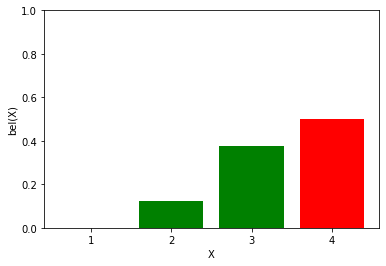

In [12]:
# mover para direita
predict(bel, 1)

show_belief(bel)

## Estima√ß√£o de estado

Para transformamos a cren√ßa em uma sinal de erro utiliz√°vel por controlador (PID) precisamos extrair um sum√°rio ou estat√≠stica da fun√ß√£o. Para o caso de vari√°veis categ√≥ricas (cujos valores n√£o possuem significado num√©rico, como as observa√ß√µes), o mais comum √© usar a **moda** da distribui√ß√£o ou o valor mais prov√°vel, tamb√©m conhecido como infer√™ncia de m√°ximo a posteriori ou MAP (do ingl√™s, _maximum a posteriori_).

No nosso dom√≠nio simples, os estados podem ser entendidos como discretiza√ß√£o de valores cont√≠nuous de posi√ß√£o, de forma que tamb√©m √© poss√≠vel obter uma estat√≠stica que combine informa√ß√£o de toda a fun√ß√£o de cren√ßa como a **m√©dia** ou valor esperado.

Essas estat√≠sticas s√£o implementadas abaixo

In [13]:
def get_mode(b):
    ''' Extract most probable belief state. '''
    mode = X[0]
    map_value = 0.0 # maximum state probability
    for i,x in enumerate(X): # implementa√ß√£o ineficiente para fins did√°ticos!
        if b[i] > map_value:
            map_value = b[i]
            mode = x
    return mode

In [14]:
def get_mean(b):
    ''' Extract mean belief state value. '''
    mean = 0.0
    for i,x in enumerate(X): # impementa√ß√£o ineficiente para fins did√°ticos!
        mean += x*b[i]
    return mean

Para nossa cren√ßa atual, essas estat√≠sticas resultam nos seguintes descritores:

In [15]:
x = get_mode(bel)
print('Mode state:', x)
x = get_mean(bel)
print('Mean state:', x)

Mode state: 4
Mean state: 3.375


## üí°Sua vez

Use as fun√ß√µes espeficiadas para simular um agente que se locomove com movimentos aleat√≥rios (ou seja, joga uma moeda a cada passo para decidir mover-se √† esquerda ou √† direita); Observe como a cren√ßa do agente se modifica. Em particular, note que a etapa de corre√ß√£o diminui a incerteza, enquanto a etapa de predi√ß√£o aumenta a incerteza. Tamb√©m repare como movimentos para as bordas diminuem a incerteza em fun√ß√£o das a√ß√µes se tornarem determin√≠sticas

In [16]:
# Implementar simula√ß√£o descrita acima

# Gera posi√ß√£o inicial aleat√≥ria entre X[0] e X[-1] (inclusive)
x_true = np.random.randint(X[0],X[-1]+1) 

# Para gerar uma a√ß√£o aleat√≥ria -1 ou 1 com mesma probabilidade:
u = 2*np.random.randint(0,2) - 1 

## üí°Sua vez

Ap√≥s familiarizar-se com o comportamento do filtro bayesiano, refa√ßa suas investiga√ß√µes em um dom√≠nio de c√©lulas linearmente dispostas de maior tamanho. Por exemplo, considere um dom√≠nio com 100 c√©lulas e um sensor imperfeito que devolve a cor errada com probabilidade 0.1. Como o comportamento do filtro se alterna?

In [17]:
# simular filtro em dom√≠nio maior
X = np.arange(1,101)     # estados (c√©lulas)
Y = [0, 1]               # observa√ß√µes: 0 - vermelho, 1 - verde
mapa = np.random.randint(0,2,len(X))      # mapa aleat√≥rio -- cont√©m cor de cada c√©lula